In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

#from altaipony.flarelc import FlareLightCurve
#from altaipony.fakeflares import aflare
#from altaipony.altai import find_iterative_median

from astropy.constants import R_sun
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

#from funcs.custom_detrending import custom_detrending, iteratively_remove_sines
from funcs.funcs import read_custom_aperture_lc
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve
from funcs.flarefit import aflare2, aflare
from funcs.model import big_model, calculate_specific_flare_flux, model

#import astropy.units as u

from scipy import optimize
from scipy.misc import derivative

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest

In [2]:
N = 200
phi_a = 6.1 * np.pi
theta_a = 7*np.pi/180
a = 2.
fwhm = 1. * np.pi
i = 89 * np.pi / 180
phi = np.linspace(0, 30*np.pi, N)
qlum = 1e28 * u.erg/u.s
R = .15 * R_sun
median = 500.
phi0= 7 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
m = big_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
              phi=phi, num_pts=50, qlum=qlum,
              Fth=Fth, R=R, median=median)
flare = aflare(phi, phi_a, fwhm, a*median,)

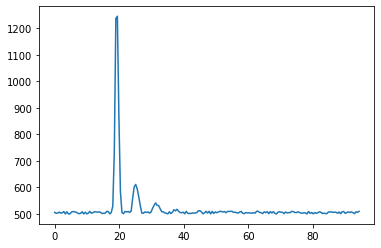

In [3]:

flux = m + np.random.rand(N) * 10.
flux_err = np.full(N, 5.)
plt.plot(phi, flux)

## Define likelihoods

In [4]:
#inclination has an uncertainty from Vsin i measurement, give it a gauss
i_mu, i_sigma = i, .1*i
# the maximum of the flux +/- one period should be right
phi_a_min, phi_a_max = 0, phi[-1]
# latitude should be 0 - 90
theta_a_min, theta_a_max = 0, np.pi/2
# amplitude and fwhm must be positive
a_min, a_max, fwhm_min, fwhm_max = 0, 1e9, 0, 1e10

theta_err = (i_mu, i_sigma, phi_a_min, phi_a_max, theta_a_min, theta_a_max, a_min, a_max, fwhm_min, fwhm_max)

In [5]:
def logit(function):
    '''Make a probability distribution
    a log probability distribution.'''
    def wrapper(*args, **kwargs):
        result = function(*args, **kwargs)
        np.seterr(divide='ignore') # ignore division by zero because you want to have the -np.inf results
        result = np.log(result)
        return result
    return wrapper

@logit
def uninformative_prior(rate, minrate, maxrate):
    '''Uninformative prior for the rates.
    Uniform within [minrate, maxrate].

    Parameters:
    -------------
    rate : float

    minrate, maxrate : float
        interval in which rate is constrained

    Return:
        Prior probability
    '''
    if ((rate >= minrate) & (rate <= maxrate)):
        return 1. / (maxrate - minrate)
    else:
        return 0
    
@logit
def gaussian_prior(x, mu, sigma):
    '''Evaluate a normalized Gaussian function
    with mu and sigma at x. NOT TESTED.'''
    if x > np.pi/2:
        return 0
    else:
        return  1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))


def calculate_posterior_value_that_can_be_passed_to_mcmc(lp):
    '''Do some checks to make sure MCMC will work. NOT TESTED.'''
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp):
        return -np.inf
    else:
        return lp

def log_prior(theta, theta_err):
    """Uniform prior for start time,
    amplitude, and duration.
    
    - Start time shoud lie approximately 
      within the observation time.
    - Duration always positive.
    - Amplitude always positive.
    
    Parameters:
    ------------
    theta : tuple
        start time, duration, amplitude
    x : array
        time array to constrain start time
    """
    phi_a, theta_a, a, fwhm, i, phi0 =  theta
    i_mu, i_sigma, phi_a_min, phi_a_max, theta_a_min, theta_a_max, a_min, a_max, fwhm_min, fwhm_max = theta_err

#     prior = (logit(gaussian_prior(i, i_mu, i_sigma)) +
#              logit(uninformative_prior(phi_a, phi_a_min, phi_a_max)) + 
#              logit(uninformative_prior(theta_a, theta_a_min, theta_a_max)) + 
#              logit(uninformative_prior(a, a_min, a_max)) + 
#              logit(uninformative_prior(fwhm, fwhm_min, fwhm_max)))

    prior = (gaussian_prior(i, i_mu, i_sigma) +
             uninformative_prior(phi_a, phi_a_min, phi_a_max) + 
             uninformative_prior(theta_a, theta_a_min, theta_a_max) + 
             uninformative_prior(a, a_min, a_max) + 
             uninformative_prior(fwhm, fwhm_min, fwhm_max) +
             uninformative_prior(phi0, 0, 2*np.pi))
    
    return calculate_posterior_value_that_can_be_passed_to_mcmc(prior)
             
            

In [6]:
def log_likelihood(theta, phi, flux, flux_err, qlum, Fth, R, median ):
    """Log likelihood function assuming 
    Gaussian uncertainties in the data points.
    SHOULDNT THIS BE POISSON?
    """
    
    phi_a, theta_a, a, fwhm, i, phi0 = theta
    model = big_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
                      phi=phi, num_pts=100, qlum=qlum,
                      Fth=Fth, R=R, median=median)
    if (model-flux < -3*flux_err).any():
      #  print(model-flux, 3*flux_err)
        return -np.inf
    else:
        val = -0.5 * np.sum((flux - model) ** 2 / flux_err**2 + np.log(flux_err**2))
        return val

def log_probability(theta, phi, flux, flux_err, qlum, Fth, R, median, theta_err):
    """Posterior probability to pass to MCMC sampler.
    """
    lp = log_prior(theta, theta_err)
    
    if not np.isfinite(lp):
        return -np.inf
    try:
        ll = log_likelihood(theta, phi, flux, flux_err, qlum, Fth, R, median)
    except:
        return -np.inf
    if np.isnan(ll):
        return -np.inf
    return lp + ll

## Set up model

## Run MCMC

In [7]:
import emcee
inits = np.array([phi_a, theta_a, a, fwhm, i, phi0]) 
pos = inits * (1. + 1e-4 * np.random.randn(100, 6))
#pos = initial + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, theta_err))
sampler.run_mcmc(pos, 100, progress=True);

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


In [8]:
i

1.5533430342749535

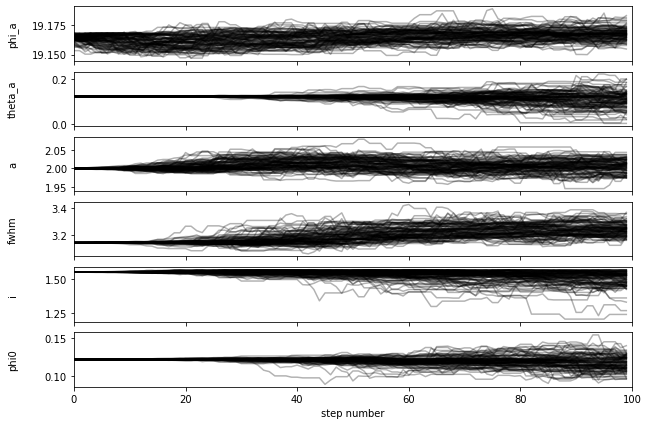

In [9]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['phi_a', 'theta_a', 'a', 'fwhm', 'i', 'phi0']
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig("mock_sample_100.png",dpi=300)

(2000, 6)


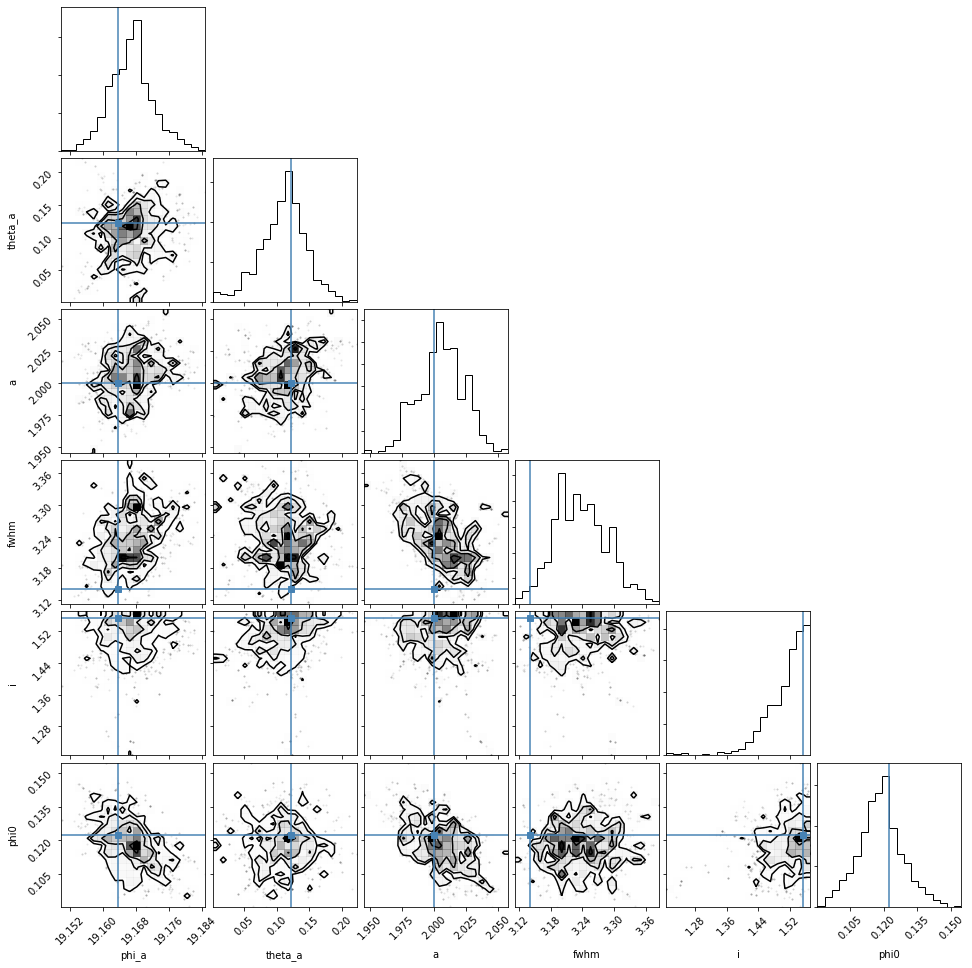

In [12]:
import corner
flat_samples = sampler.get_chain(discard=80, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels, truths=[phi_a, theta_a, a, fwhm,i, phi0]);
plt.savefig("corner_mock_sample_100.png",dpi=300)

In [ ]:
.15/np.pi*180,.6/np.pi*180

No handles with labels found to put in legend.


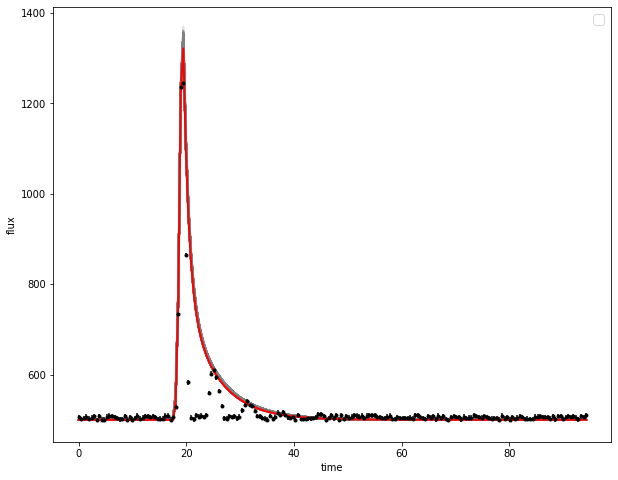

In [13]:
inds = np.random.randint(len(flat_samples), size=1500)
plt.figure(figsize=(10,8))
#t_ = np.linspace(target.view_start, target.view_stop,800)
#plt.scatter(flck.time, flck.flux, s=1)
#plt.scatter(phi, flux+200, s=10, c="grey")
plt.errorbar(phi, flux, yerr=flux_err, fmt=".k", capsize=0)



for ind in inds:
    sample = flat_samples[ind]
    phi_a, fwhm, a = sample[[0,3,2]]
    plt.plot(phi, aflare2(phi, phi_a, fwhm/2, a*median, median), c="grey", alpha=0.05, linewidth=2)
 #   plt.plot(phi, aflare2(phi, *sample[[0,3,2]], median)+200, "C1", alpha=0.05)
#plt.plot(phi, flare+median, c="red", linewidth=2)
#plt.plot(flc.time, truth, "k", label="init gues", linewidth=1)
plt.plot(phi, flare+median, c="r",linewidth=2)
plt.legend(fontsize=14)
#plt.xlim(10, 13)
plt.xlabel("time")
plt.ylabel("flux");
#plt.xlim(target.view_start, target.view_stop);
#plt.ylim(500,840)
#plt.yscale("log")

In [14]:
samples = sampler.chain[:, 40:, :].reshape((-1, ndim))
#samples[:, 2] = np.exp(samples[:, 2])
t0_mcmc, dur_mcmc, ampl_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
t0_mcmc, dur_mcmc, ampl_mcmc

ValueError: too many values to unpack (expected 3)

In [ ]:
e_t0 = (t0_mcmc[1] + t0_mcmc[2])/2.
e_dur = (dur_mcmc[1] + dur_mcmc[2])/2.
e_ampl = (ampl_mcmc[1] + ampl_mcmc[2])/2.

In [ ]:

def ED(t, t0, dur, ampl, median):
    x = t * 60.0 * 60.0 * 24.0
    return np.sum(np.diff(x) * aflare(t, t0, dur, ampl)[:-1]) / (dur * 6 * median)

In [ ]:

def t0_ED(x):
    return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
def dur_ED(x):
    return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
def ampl_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
def median_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

In [ ]:
check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
assert E_median == pytest.approx(E_median,rel=1e-4)
e_median, median

In [ ]:
EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
EDval,e_ED

In [ ]:
with open(f"{CWD}/data/summary/results.csv", "a") as k:
    stri = (f"{target.prefix} {target.ID},{EDval:.0f},{e_ED:.0f},"\
            f"{t0_mcmc[0]:.5f},{e_t0:.5f},"\
            f"{dur_mcmc[0]*6:.5f},{e_dur*6:.5f},"\
            f"{ampl_mcmc[0]/median:.5f},{e_ampl/median:.5f}\n"\
            f"{period.value:.2f}")
   # stri = "ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot_h\n"
    k.write(stri)